# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Our first Python Spark SQL example") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
path = "mini_sparkify_event_data.json"
user_log = spark.read.json(path)

In [4]:
user_log.createOrReplaceTempView("data")


In [5]:
#checking for any missing userId's or sessionId's, none
spark.sql('''
        select *
        from data
        where userId is null or sessionId is null
''').show()

#noticed that there were null songs, that is when page's value is not'next song'
spark.sql('''
        select distinct page
        from data
        where song is not null
''').show(40)

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+

+--------+
|    page|
+--------+
|NextSong|
+--------+



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [6]:
spark.udf.register("day", lambda x: str(datetime.datetime.fromtimestamp(x / 1000.0).day))
spark.udf.register("time", lambda x: str(datetime.datetime.fromtimestamp(x / 1000.0)))

<function __main__.<lambda>(x)>

In [7]:
pivot_data = spark.sql('''
        
        select userId, sessionId, page, count(page) as page_count
        from data
        where userId != ""
        group by userId, sessionId, page
        order by userId, sessionId, page_count desc
        

''')
pivot_data.createOrReplaceTempView("pivot_data")


In [8]:
transformed_data = spark.sql('''
            select userId, sessionId,
                sum(CancellationConfirmation) as CancellationConfirmation,
                sum(SubmitUpgrade) as SubmitUpgrade,
                sum(Upgrade) as Upgrade,
                sum(Help) as Help,
                sum(ThumbsUp) as ThumbsUp,
                sum(NextSong) as NextSong,
                sum(AddFriend) as AddFriend,
                sum(AddtoPlaylist) as AddtoPlaylist,
                sum(Settings) as Settings,
                sum(About) as About,
                sum(SaveSettings) as SaveSettings,
                sum(Logout) as Logout,
                sum(RollAdvert) as RollAdvert,
                sum(Downgrade) as Downgrade,
                sum(Home) as Home,
                sum(ThumbsDown) as ThumbsDown,
                sum(SubmitDowngrade) as SubmitDowngrade,
                sum(Cancel) as Cancel
                
                from (select pivot_data.*,
                    case when page = "Cancellation Confirmation" then page_count else 0 end as CancellationConfirmation,
                    case when page = "Submit Upgrade" then page_count  else 0 end as SubmitUpgrade,
                    case when page = "Upgrade" then page_count  else 0 end as Upgrade,
                    case when page = "Help" then page_count  else 0 end as Help,
                    case when page = "Thumbs Up" then page_count  else 0 end as ThumbsUp,
                    case when page = "NextSong" then page_count  else 0 end as NextSong,
                    case when page = "Add Friend" then page_count  else 0 end as AddFriend,
                    case when page = "Add to Playlist" then page_count  else 0 end as AddtoPlaylist,
                    case when page = "Settings" then page_count  else 0 end as Settings,
                    case when page = "About" then page_count  else 0 end as About,
                    case when page = "Save Settings" then page_count  else 0 end as SaveSettings,
                    case when page = "Logout" then page_count  else 0 end as Logout,
                    case when page = "Roll Advert" then page_count  else 0 end as RollAdvert,
                    case when page = "Downgrade" then page_count  else 0 end as Downgrade,
                    case when page = "Home" then page_count  else 0 end as Home,
                    case when page = "Thumbs Down" then page_count  else 0 end as ThumbsDown,
                    case when page = "Submit Downgrade" then page_count  else 0 end as SubmitDowngrade,
                    case when page = "Cancel" then page_count  else 0 end as Cancel
                from pivot_data) pivot_ext
                group by userId, sessionId
                order by userId, sessionId asc
''')
transformed_data.createOrReplaceTempView("transformed")

In [9]:
spark.sql('''
        
        select userId, count(*) as sessions
        FROM (select distinct userId, sessionId
                from data
                where userId != "")
        group by userId
        order by sessions Desc
        

''')
#There are matching sessionId's between 

DataFrame[userId: string, sessions: bigint]

In [58]:
transform_vector = spark.sql('''
        select userId, sum(CancellationConfirmation) as CancellationConfirmation,
                sum(SubmitUpgrade) as SubmitUpgrade,
                sum(Upgrade) as Upgrade,
                sum(Help) as Help,
                sum(ThumbsUp) as ThumbsUp,
                sum(NextSong) as NextSong,
                sum(AddFriend) as AddFriend,
                sum(AddtoPlaylist) as AddtoPlaylist,
                sum(Settings) as Settings,
                sum(About) as About,
                sum(SaveSettings) as SaveSettings,
                sum(Logout) as Logout,
                sum(RollAdvert) as RollAdvert,
                sum(Downgrade) as Downgrade,
                sum(Home) as Home,
                sum(ThumbsDown) as ThumbsDown,
                sum(SubmitDowngrade) as SubmitDowngrade,
                sum(Cancel) as Cancel
        from transformed
        group by userId
''')
transform_vector.createOrReplaceTempView("transform_vector")

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [59]:
from pyspark.ml.feature import Binarizer
from pyspark.ml.feature import VectorAssembler

ignore = ['userId',"CancellationConfirmation" ]



assembler = VectorAssembler(
  inputCols=[x for x in transform_vector.columns if x not in ignore], outputCol="features"
)


assembled = assembler.transform(transform_vector)

In [60]:
assembled.createOrReplaceTempView("assembled")
assembled.toPandas()

,userId,CancellationConfirmation,SubmitUpgrade,Upgrade,Help,ThumbsUp,NextSong,AddFriend,AddtoPlaylist,Settings,About,SaveSettings,Logout,RollAdvert,Downgrade,Home,ThumbsDown,SubmitDowngrade,Cancel,features
0,100010,0,0,2,2,17,275,4,7,0,1,0,5,52,0,11,5,0,0,"[0.0, 2.0, 2.0, 17.0, 275.0, 4.0, 7.0, 0.0, 1...."
1,200002,0,1,2,2,21,387,4,8,3,3,0,5,7,5,20,6,0,0,"[1.0, 2.0, 2.0, 21.0, 387.0, 4.0, 8.0, 3.0, 3...."
2,125,1,0,0,0,0,8,0,0,0,0,0,0,1,0,0,0,0,1,"(0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, ..."
3,124,0,0,0,23,171,4079,74,118,20,7,6,59,4,41,176,41,0,0,"[0.0, 0.0, 23.0, 171.0, 4079.0, 74.0, 118.0, 2..."
4,51,1,0,0,12,100,2111,28,52,12,2,1,24,0,23,75,21,0,1,"[0.0, 0.0, 12.0, 100.0, 2111.0, 28.0, 52.0, 12..."
5,7,0,0,2,1,7,150,1,5,3,0,1,3,16,0,10,1,0,0,"[0.0, 2.0, 1.0, 7.0, 150.0, 1.0, 5.0, 3.0, 0.0..."
6,15,0,0,0,8,81,1914,31,59,16,2,2,27,1,28,93,14,0,0,"[0.0, 0.0, 8.0, 81.0, 1914.0, 31.0, 59.0, 16.0..."
7,54,1,1,1,17,163,2841,33,72,17,5,3,36,47,39,129,29,1,1,"[1.0, 1.0, 17.0, 163.0, 2841.0, 33.0, 72.0, 17..."
8,155,0,1,2,9,58,820,11,24,5,2,0,14,8,12,30,3,0,0,"[1.0, 2.0, 9.0, 58.0, 820.0, 11.0, 24.0, 5.0, ..."
9,100014,1,0,0,2,17,257,6,7,1,0,0,3,2,3,7,3,0,1,"[0.0, 0.0, 2.0, 17.0, 257.0, 6.0, 7.0, 1.0, 0...."


In [62]:
spark.sql('''
        
       
        select userId, CancellationConfirmation
        from assembled
        where CancellationConfirmation > 0   
        order by userId    
''').toPandas()


,userId,CancellationConfirmation
0,100001,1
1,100003,1
2,100005,1
3,100006,1
4,100007,1
5,100009,1
6,100011,1
7,100012,1
8,100013,1
9,100014,1


In [66]:
assembled = spark.sql('''
            select userId, features, CancellationConfirmation
            from assembled
            group by userId, features, CancellationConfirmation
            order by userId
            
''')


spark.sql('''
            select userId, features, CancellationConfirmation
            from assembled
            group by userId, features, CancellationConfirmation
            order by userId
            
''')


DataFrame[userId: string, features: vector, CancellationConfirmation: bigint]

In [65]:
'''spark.sql('''
        
        select final.userId, final.features, coalesce(ok.CancellationConfirmation,0) as churn
        from final
        left join(
        select userId, CancellationConfirmation
        from assembled
        where CancellationConfirmation > 0 ) as ok
        on final.userId = ok.userId 
           


''').toPandas()
'''

,userId,features,churn
0,100010,"[(0.0, 1.0, 0.0, 2.0, 24.0, 0.0, 1.0, 0.0, 0.0...",0
1,200002,"[(0.0, 1.0, 0.0, 2.0, 34.0, 0.0, 1.0, 0.0, 0.0...",0
2,125,"[(0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0,...",1
3,124,"[(0.0, 0.0, 0.0, 8.0, 150.0, 1.0, 5.0, 0.0, 0....",0
4,51,"[(0.0, 0.0, 1.0, 2.0, 120.0, 0.0, 4.0, 0.0, 0....",1
5,7,"[(0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0,...",0
6,15,"[(0.0, 0.0, 1.0, 4.0, 98.0, 3.0, 3.0, 2.0, 0.0...",0
7,54,"[(0.0, 0.0, 0.0, 5.0, 69.0, 0.0, 0.0, 0.0, 0.0...",1
8,155,"[[0.0, 1.0, 2.0, 6.0, 70.0, 2.0, 1.0, 2.0, 0.0...",0
9,100014,"[(0.0, 0.0, 1.0, 1.0, 52.0, 0.0, 1.0, 1.0, 0.0...",1


In [67]:

final = assembled.select(['features',"CancellationConfirmation"])

In [90]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(final)

# Normalize each feature to have unit standard deviation.
scaledData = scalerModel.transform(final)
scaledData.show()

+--------------------+------------------------+--------------------+
|            features|CancellationConfirmation|      scaledFeatures|
+--------------------+------------------------+--------------------+
|[0.0,0.0,1.0,37.0...|                       0|[0.0,0.0,0.138072...|
|[1.0,1.0,18.0,148...|                       0|[1.36263125082666...|
|[0.0,2.0,1.0,8.0,...|                       1|[0.0,0.7816967554...|
|(17,[3,4,5,6,10,1...|                       0|(17,[3,4,5,6,10,1...|
|(17,[2,3,4,6,10,1...|                       1|(17,[2,3,4,6,10,1...|
|[3.0,8.0,6.0,35.0...|                       0|[4.08789375247999...|
|[0.0,4.0,2.0,7.0,...|                       1|[0.0,1.5633935109...|
|(17,[3,4,5,6,7,10...|                       1|(17,[3,4,5,6,7,10...|
|[0.0,0.0,3.0,19.0...|                       1|[0.0,0.0,0.414216...|
|[0.0,4.0,6.0,37.0...|                       0|[0.0,1.5633935109...|
|[1.0,4.0,6.0,23.0...|                       1|[1.36263125082666...|
|[0.0,2.0,2.0,17.0...|            

In [91]:

splits = scaledData.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [92]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, featuresCol="features", labelCol="CancellationConfirmation")

# Fit the model
lrModel = lr.fit(train_df)

In [93]:
predict_train=lrModel.transform(train_df)
predict_test=lrModel.transform(test_df)
predict_test.select("CancellationConfirmation","prediction").show(10)

from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator=BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol="CancellationConfirmation")
predict_test.select("CancellationConfirmation","rawPrediction","prediction","probability").show(5)
print("The area under ROC for train set is {}".format(evaluator.evaluate(predict_train)))
print("The area under ROC for test set is {}".format(evaluator.evaluate(predict_test)))

+------------------------+----------+
|CancellationConfirmation|prediction|
+------------------------+----------+
|                       1|       1.0|
|                       0|       0.0|
|                       1|       1.0|
|                       0|       0.0|
|                       0|       0.0|
|                       0|       0.0|
|                       0|       0.0|
|                       1|       1.0|
|                       0|       0.0|
|                       0|       0.0|
+------------------------+----------+
only showing top 10 rows

+------------------------+--------------------+----------+--------------------+
|CancellationConfirmation|       rawPrediction|prediction|         probability|
+------------------------+--------------------+----------+--------------------+
|                       1|[-0.0373634832635...|       1.0|[0.49066021571032...|
|                       0|[1.62248870503472...|       0.0|[0.83513806673405...|
|                       1|[-0.037363483263

In [94]:
# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

trainingSummary = lrModel.summary
# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
trainingSummary.roc.show()
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

print("f1: " + str(trainingSummary.objectiveHistory))

print("accuracy: " + str(trainingSummary.accuracy))

Coefficients: (17,[16],[1.6598521883])
Intercept: -1.6224887050347236
+---+---+
|FPR|TPR|
+---+---+
|0.0|0.0|
|0.0|1.0|
|1.0|1.0|
|1.0|1.0|
+---+---+

areaUnderROC: 1.0
f1: [0.5640559390452035, 0.5488857548068444, 0.5214492854869508, 0.5031453531129038, 0.4998588356476603, 0.4958400287286332, 0.49419364074277544, 0.4936335391634893, 0.49362060820246845, 0.49362024288211925, 0.4936200617342198]
accuracy: 1.0


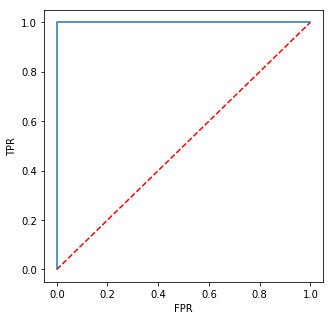

In [95]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(trainingSummary.roc.select('FPR').collect(),
         trainingSummary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.